In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = '../../Data/Spitzer_ALMA_sample.csv'
spitzer = pd.read_csv(data_path, sep=',', skipinitialspace=True, na_values=['#NAME?'])

In [3]:
spitzer['FLC2H2']

0     1.320000e-14
1     2.230000e-14
2     1.900000e-13
3     2.130000e-14
4     8.960000e-15
          ...     
58    1.270000e-14
59    3.120000e-14
60    1.110000e-14
61    1.610000e-14
62    1.260000e-14
Name: FLC2H2, Length: 63, dtype: float64

In [7]:
param = 'FLC2H2'
err_param = 'ERRC2H2'

In [8]:
upper_limits = spitzer[err_param] > spitzer[param]

In [13]:
uppers = ['upp' if upp else 'norm' for upp in upper_limits]

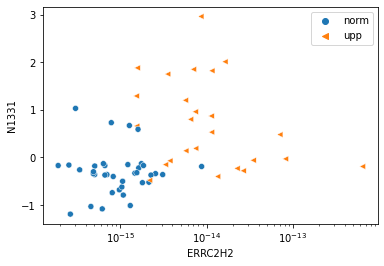

In [23]:
markers = {'upp':'<', 'norm':'o'}
ax = sns.scatterplot(data=spitzer, x='ERRC2H2', y='N1331', style=uppers, hue=uppers, markers=markers)
ax.set_xscale('log')

In [26]:
correct_params = spitzer[param].copy()
correct_params[upper_limits] = spitzer[err_param][upper_limits]

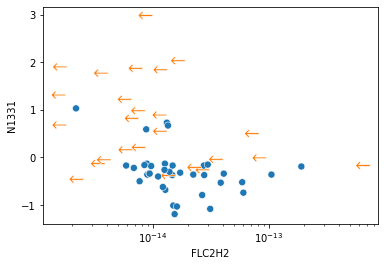

In [41]:
markers = {'upp':'$\leftarrow$', 'norm':'o'}
sizes = {'upp':230, 'norm':50}
ax = sns.scatterplot(data=spitzer, x=correct_params, y='N1331', style=uppers, hue=uppers,
                     markers=markers, size=uppers, sizes=sizes, legend=False)
ax.set_xscale('log')

In [62]:
# Now make a function to generate the appropriate marker and size dictionaries!?
# first define a function to identify limits:

def upp_mask(data, parameter, parameter_err):
    return (data[parameter_err] > spitzer[parameter]).values

# second define a function to map upper limit kind using mask
# kinds: y upper-limit, x upper-limit
def map_limits_x(upp_mask_x, kind='west'):
    # use norm to define regular point
    return [kind if upp else 'norm' for upp in upp_mask_x]

# third define a function to map upper limit kind given two masks
# kinds: y upper-limit, x upper-limit, and xy upper-limit
def map_limits_xy(upp_mask_x, upp_mask_y):
    assert upp_mask_x.size == upp_mask_y.size, 'Could not map using arrays of different size'
    upp_mask_xy = upp_mask_x & upp_mask_y

    limits = []
    for i in range(upp_mask_x.size):
        if upp_mask_xy[i]:
            limits.append('southwest')
        elif upp_mask_x[i]:
            limits.append('west')
        elif upp_mask_y[i]:
            limits.append('south')
        else:
            limits.append('norm')
    return limits

# now given x-param and y-param,
def uppers_func(data, x_param, y_param, x_param_err, y_param_err):
    # assuming all are given then
    # calculate masks for x and y upper limits separately
    x_upp_mask = upp_mask(data, x_param, x_param_err)
    y_upp_mask = upp_mask(data, y_param, y_param_err)

    # now map masks to appropriate kind of arrow: west, southwest, and south
    limits = map_limits_xy(x_upp_mask, y_upp_mask)
    return limits

# the last function will only work if both parameters have errors
# let's not rely on that so,

def uppers_funcv2(data, x_param, y_param, x_param_err=None, y_param_err=None):
    # This function will take parameters and errors; the errors may be None
    if x_param_err and y_param_err:
        return uppers_func(data, x_param, y_param, x_param_err, y_param_err)
    elif x_param_err:
        z_upp_mask = upp_mask(data, x_param, x_param_err)
        return map_limits_x(z_upp_mask, kind='west')
    elif y_param_err:
        z_upp_mask = upp_mask(data, y_param, y_param_err)
        return map_limits_x(z_upp_mask, kind='south')
    else:
        raise ValueError('These parameters don\'t have upper limits!')

# I think the functions above will work for most purposes
# however, I need the original upper limit mask to make an array with the
# correct data coordinates to plot on; the ones with the placeholders replaced with the errors (upper limits)
# So instead of using the above we'll make a function that will return
# both the limits and the corrected parameter arrays

def correct_param(data, z_param, z_param_err, z_upp_mask):
    z_correct_params = data[z_param].copy()
    z_correct_params[z_upp_mask] = data[z_param_err][z_upp_mask]
    return z_correct_params

def limit_arrays(data, x_param, y_param, x_param_err=None, y_param_err=None):
    if x_param_err and y_param_err:
        x_upp_mask = upp_mask(data, x_param, x_param_err)
        y_upp_mask = upp_mask(data, y_param, y_param_err)

        x_correct_params = correct_param(data, x_param, x_param_err, x_upp_mask)
        y_correct_params = correct_param(data, y_param, y_param_err, y_upp_mask)
        limits = map_limits_xy(x_upp_mask, y_upp_mask)
    elif x_param_err:
        x_upp_mask = upp_mask(data, x_param, x_param_err)
        x_correct_params = correct_param(data, x_param, x_param_err, x_upp_mask)
        y_correct_params = data[y_param]
        limits = map_limits_x(x_upp_mask, kind='west')
    elif y_param_err:
        y_upp_mask = upp_mask(data, y_param, y_param_err)
        y_correct_params = correct_param(data, y_param, y_param_err, y_upp_mask)
        x_correct_params = data[x_param]
        limits = map_limits_x(y_upp_mask, kind='south')
    else:
        raise ValueError('These parameters don\'t have upper limits!')
    return x_correct_params, y_correct_params, limits



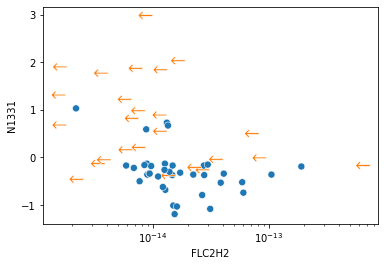

In [63]:
# Let's put our functions into test and see if they can replicate the last example
# First let's define the dictionaries seaborn will use to match markers, colors, and sizes
markers = {'west':'$\leftarrow$', 'southwest':'$\swarrow$', 'south':'$\downarrow$', 'norm':'o'}
sizes = {'west': 230, 'southwest': 230, 'south': 230, 'norm':50}

# Now let's define what parameters we will be plotting
x_param = 'FLC2H2'
y_param = 'N1331'
x_err_param = 'ERRC2H2'
y_err_param = None

x_correct_params, y_correct_params, limits = limit_arrays(spitzer, x_param, y_param, x_err_param, y_err_param )
ax = sns.scatterplot(x=x_correct_params, y=y_correct_params, style=limits, hue=limits,
                     markers=markers, size=limits, sizes=sizes, legend=False)
ax.set_xscale('log')


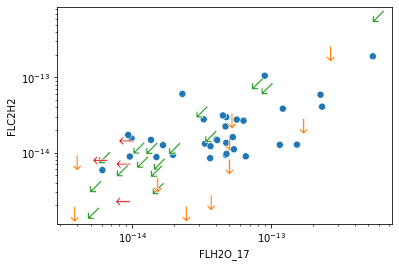

In [65]:
# We can try different parameters!
# it looks super nice!!
y_param = 'FLC2H2'
x_param = 'FLH2O_17'
y_err_param = 'ERRC2H2'
x_err_param = 'ERRH2O_17'

x_correct_params, y_correct_params, limits = limit_arrays(spitzer, x_param, y_param, x_err_param, y_err_param )
ax = sns.scatterplot(x=x_correct_params, y=y_correct_params, style=limits, hue=limits,
                     markers=markers, size=limits, sizes=sizes, legend=False)
ax.set_xscale('log')
ax.set_yscale('log')